In [107]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval, LinearStretch
from astropy.wcs import WCS
import astrocal

In [135]:
# Choose the image to analyze
folder_path = "P:/Aurélien/Astronomie/Astrophoto/01-Ciel profond/NGC7331_2024-10-11_RC6_ASI1600MM_L_20s_139/LIGHT-L"
image_path = glob.glob(folder_path + "/*.fits")[20]

In [136]:
# Load the image
with fits.open(image_path) as hdul:
    hdu = hdul[0].copy()

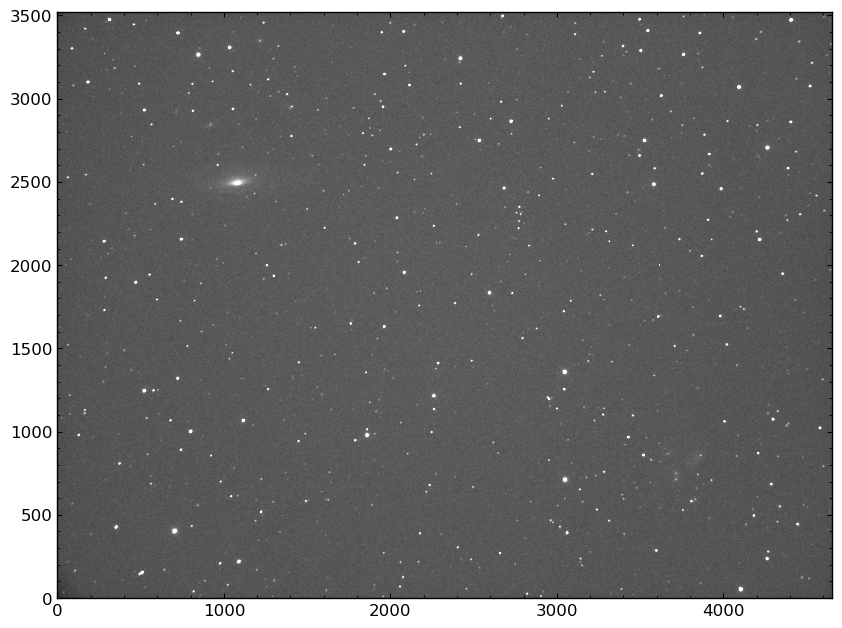

In [137]:
# Show the image
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
norm = ImageNormalize(hdu.data, interval=ZScaleInterval(), stretch=LinearStretch())
ax.imshow(hdu.data, cmap="gray", origin='lower', norm=norm)
plt.show()

Set MJD-AVG to 60594.946501 from DATE-AVG'. [astropy.wcs.wcs]


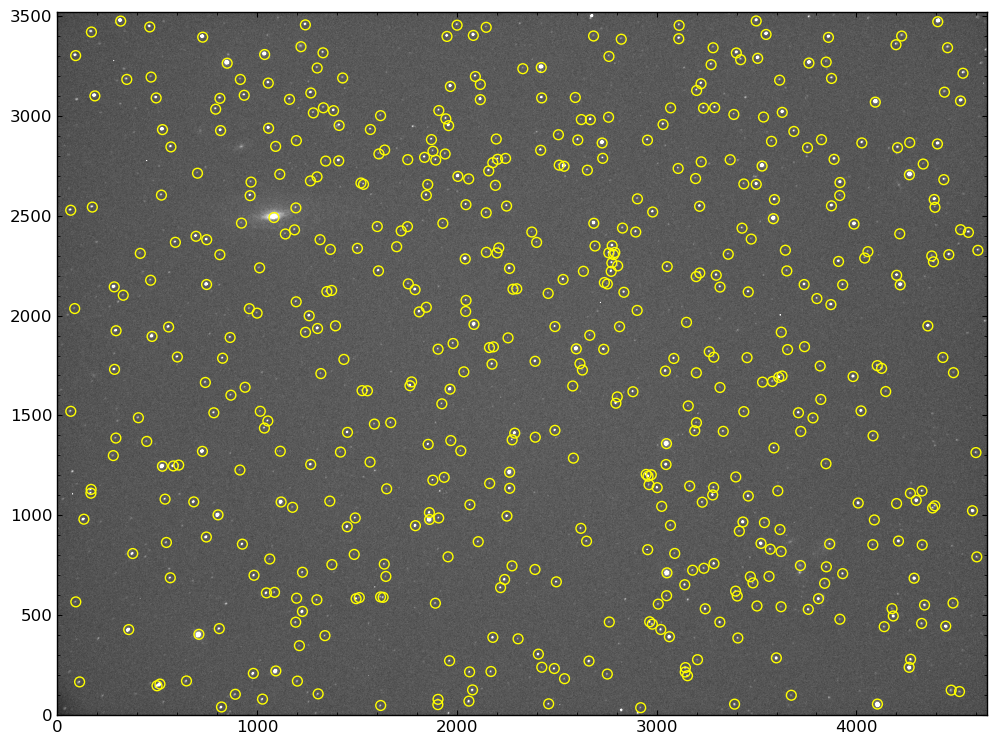

In [138]:
sources = astrocal.find_sources(hdu, fwhm=9, threshold=7, plot=True)

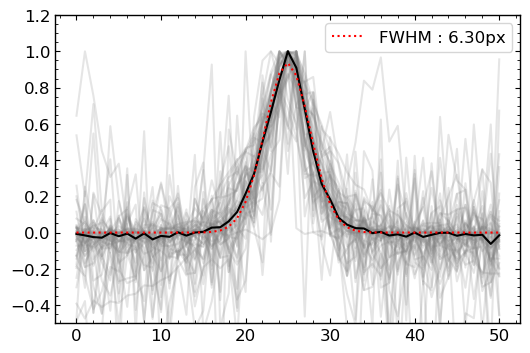

FWHM : 3.60 arcsec"


Set MJD-AVG to 60594.946501 from DATE-AVG'. [astropy.wcs.wcs]


In [139]:
fwhm = astrocal.fwhm_estimate(hdu, sources=sources, angle=True, plot=True, verbose=True)

In [140]:
phot_table, apertures, annulus_apertures = astrocal.relative_aperture_photometry(hdu, sources, fwhm, mask=None)

In [144]:
# Plate solve
try:
    phot_table.sort("aper_sum_bkgsub", reverse=True)
    wcs_sources = phot_table[:150]
    wcs_sources.rename_column("xcenter", "xcentroid")
    wcs_sources.rename_column("ycenter", "ycentroid")
    wcs_sources['xcentroid'] = wcs_sources['xcentroid'].value
    wcs_sources['ycentroid'] = wcs_sources['ycentroid'].value
    wcs = astrocal.plate_solve(hdu, wcs_sources)
except:
    print("Plate solving failed, trying with Astrometry.net")
    from astroquery.astrometry_net import AstrometryNet
    ast = AstrometryNet()
    wcs = WCS(ast.solve_from_image(image_path, solve_timeout=120, force_image_upload=True))
    
hdu.header.update(wcs.to_header())

Solving.............................................Plate solving failed, trying with Astrometry.net
Solving.................

In [145]:
calib_sources = astrocal.query_catalog(hdu)

In [146]:
matched_phot_table = astrocal.cross_match(hdu, apertures, phot_table, calib_sources)

ZP : 22.62


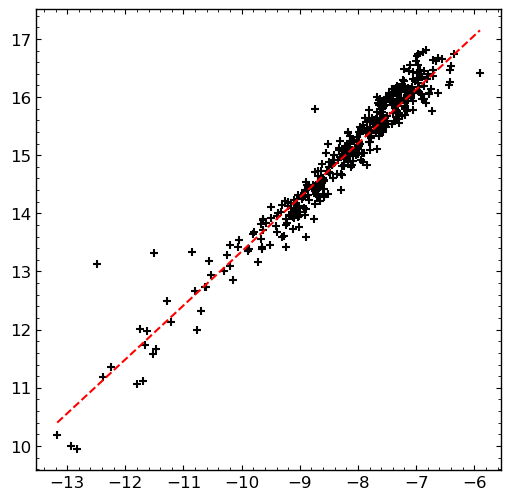

In [147]:
ransac = astrocal.ZP_ransac(matched_phot_table, mag_bounds=(2,20), plot=True, verbose=True)

In [148]:
phot_table = astrocal.calibrate_sources(phot_table, ransac)

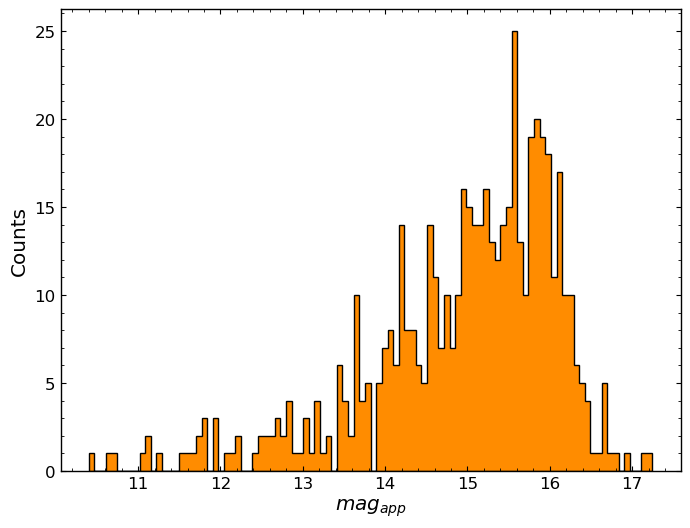

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.hist(phot_table['app_mag'], bins=100, histtype='stepfilled', edgecolor='k', color='darkorange')
ax.set_xlabel("$mag_{app}$")
ax.set_ylabel("Counts")
plt.show()